just run all the cells and replace target_url in it's cell with a url that points towards your image, and replace dummy with a 1-token concept related to the image (e.g. girl, boy, plant, *)

In [1]:
!pip install git+https://github.com/openai/CLIP -q
!apt-get install git-lfs
!pip install transformers -q
from google.colab import output
output.clear()

In [2]:
import clip
import torch
from torch import optim, nn
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from tqdm.auto import trange, tqdm
from PIL import Image
import requests
from io import BytesIO
import random

In [3]:
model_name = 'ViT-L/14'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = clip.load(model_name, jit=False)[0].to(device)

def forward(self, dummy='*', prefixes=[""]):
    tokens = clip.tokenize(random.choice(prefixes).format(dummy)).to(device)
    x = self.encode_text(tokens)
    return x

In [4]:
for i in model.token_embedding.parameters():
    i.requires_grad = True

In [5]:
lr = 0.013
model.token_embedding.requires_grad = True
opt = optim.Adam(model.token_embedding.parameters(), lr)

Image to optimize towards:


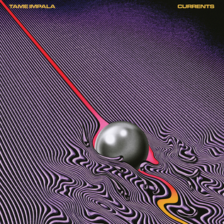

In [6]:
target_url = "https://upload.wikimedia.org/wikipedia/en/9/9b/Tame_Impala_-_Currents.png" #@param {type:"string"}
response = requests.get(target_url)
pil_image = Image.open(BytesIO(response.content)).convert("RGB")
pil_image_resized = tf.resize(pil_image, model.visual.input_resolution)
pil_image_cropped = tf.center_crop(pil_image_resized, [model.visual.input_resolution]*2)
image_tensor = tf.to_tensor(pil_image_cropped)
print("Image to optimize towards:")
pil_image_cropped

In [7]:
#@markdown get image embedding,

with torch.no_grad():
    images = image_tensor.to(device).unsqueeze(0)
    image_encoding = model.encode_image(images)
    # future proofing for multiple images 
    image_encoding = image_encoding.mean(0)


In [8]:
#@markdown automatically find best token (messy, old code)
from huggingface_hub import snapshot_download
import os
input_folder = snapshot_download(repo_id="crumb/ViT-L-14-Token-Embeddings")
table = []
input_folder = input_folder + "/embeddings"
filenames = os.listdir(input_folder)
for filename in filenames:
    fixed_name = input_folder + "/" + filename.rjust(9, "0")
    filename = input_folder + "/" + filename
    !mv $filename $fixed_name
filenames = sorted(os.listdir(input_folder))
for filename in filenames:
    x = torch.load(input_folder + "/" + filename)
    table.append(x)
table = torch.cat(table, 0)
output.clear()
def sph_dist(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    l = (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)#.mean()
    return l 
tokenizer = clip.simple_tokenizer.SimpleTokenizer()
x = [sph_dist(image_encoding, table).argmin().item()]
tok = tokenizer.decode(x)[:-1]
dummy_token = x[0]
dummy = tok

print("Best token:", dummy)

Best token: currents


In [9]:
#@markdown prompt templates (from sd text inversion hf)
type_of_concept = "object" #@param ["object", "style"]
if type_of_concept=="object":
    prefixes = [
        "a photo of {}",
        "a rendering of {}",
        "a cropped photo of {}",
        "the photo of {}",
        "a photo of a clean {}",
        "a photo of a dirty {}",
        "a dark photo of {}",
        "a photo of my {}",
        "a photo of the cool {}",
        "a close-up photo of a {}",
        "a bright photo of the {}",
        "a cropped photo of a {}",
        "a photo of {}",
        "a good photo of {}",
        "a close-up photo of {}",
        "a rendition of {}",
        "a photo of clean {}",
        "a rendition of {}",
        "a photo of nice {}",
        "a good photo of {}",
        "a photo of nice {}",
        "a photo of small {}",
        "a photo of weird {}",
        "a photo of large {}",
        "a photo of cool {}",
        "a photo of small {}"
    ]
elif type_of_concept=="style":
    prefixes = [
        "a painting in the style of {}",
        "a rendering in the style of {}",
        "a cropped painting in the style of {}",
        "the painting in the style of {}",
        "a clean painting in the style of {}",
        "a dirty painting in the style of {}",
        "a dark painting in the style of {}",
        "a picture in the style of {}",
        "a cool painting in the style of {}",
        "a close-up painting in the style of {}",
        "a bright painting in the style of {}",
        "a cropped painting in the style of {}",
        "a good painting in the style of {}",
        "a close-up painting in the style of {}",
        "a rendition in the style of {}",
        "a nice painting in the style of {}",
        "a small painting in the style of {}",
        "a weird painting in the style of {}",
        "a large painting in the style of {}",
    ]

In [10]:
# i think these settings are a sweet spot?
# if you can find a set that trains longer + gets better results ping me
# accumulate is so low because without the randomness it's unstable and ... over..fits???
accumulate = 2
steps = 65
steps = steps * accumulate
loop = trange(steps, desc="Steps")

losses = []
def track_loss(loss):
    global losses 
    losses.append(loss.item())

for step in loop:
    # ---
    encoding = forward(model, dummy, prefixes)
    loss = sph_dist(encoding,image_encoding).mean() / accumulate
    loss.backward()
    # ---
    if step%accumulate==0:
        grads = model.token_embedding.weight.data
        index_grads_to_zero = (torch.arange(len(model.token_embedding.weight.data)) != dummy_token)
        grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)
        opt.step()
        opt.zero_grad()
        track_loss(loss)

Steps:   0%|          | 0/130 [00:00<?, ?it/s]

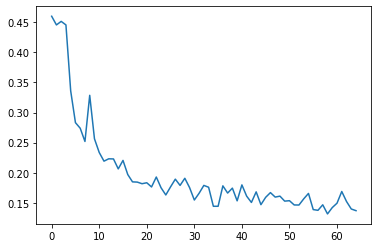

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [12]:
#@markdown zip concept for easy download
import os
import shutil

if not os.path.exists("concept"):
    os.mkdir("concept")

placeholder_token = "<image>"

learned_embeds_dict = {placeholder_token: model.token_embedding.weight.data[dummy_token].detach().cpu()}
torch.save(learned_embeds_dict, "concept/learned_embeds.bin")

text_file = open("concept/token_identifier.txt", "w")
text_file.write(placeholder_token)
text_file.close()

type_file = open("concept/type_of_concept.txt","w")
type_file.write(type_of_concept)
type_file.close()

shutil.make_archive("concept", 'zip', "concept")

'/content/concept.zip'

In [13]:
#@markdown convert to old-style for other webuis, saved as emb.pt <br>
#@markdown todo: test if this even works, i dont use other webuis a lot
n = {'string_to_token': {"<image>": torch.tensor(len(model.token_embedding.weight.data))},
     'string_to_param': {
         torch.nn.ParameterDict({
             "<image>": model.token_embedding.weight.data[dummy_token].detach().cpu().unsqueeze(0)
         })
     }}
torch.save(n, "image.pt")

### how to use this concept

---

create a model-type repository on [huggingface](https://huggingface.co/).

put it's name along with your huggingface token (https://huggingface.co/settings/tokens) in the next cell, run it.

Now you can use this concept with my notebook, [doohickey](https://colab.research.google.com/github/aicrumb/doohickey/blob/main/Doohickey_Diffusion.ipynb) to generate images like the one you inverted here.

Under `Model Customizations` there's a cell that says `load textual-inversion concepts from 🤗 hub`. After the first item, add a comma and put your username and name of the repository you created in quotes. It should look something like
```
["sd-concepts-library/cat-toy", "username/my-concept"]
```

After that's done, you can use the concept to generate images. Under `Main Parameters` inside the prompt section, write whatever prompt you want and treat `<image>` as if it were a word describing your image.

In [15]:
from huggingface_hub import HfApi
repo_id = "myUsername/myConcept" #@param {type:"string"}
hf_token = "hf_example" #@param {type:"string"}
api = HfApi()
api.upload_folder(
    folder_path="concept",
    path_in_repo="",
    repo_id=repo_id,
    repo_type="model",
    ignore_patterns="",
    token = hf_token
)

'https://huggingface.co/crumb/test-concept/tree/main/'